# Evaluate slot representation

In [117]:
import dnnlib
import torch
import legacy
from matplotlib import pyplot as plt
import matplotlib.image
import numpy as np
import os
import pickle

BASE_PATH = "./training-runs/"
DATASET_NAME = "bedroom"

In [118]:
folders = os.listdir(BASE_PATH)
models_by_dataset_name = {x.split("-")[2]: os.path.join(BASE_PATH, x, "network-snapshot.pkl") for x in folders}
models_by_dataset_name

{'dogs': '../../mlcloud_mount/models/pg-training-runs/00105-fastgan-dogs-gpus4-batch64-sre/network-snapshot.pkl',
 'dogs_faces': '../../mlcloud_mount/models/pg-training-runs/00113-fastgan-dogs_faces-gpus4-batch64-1Mimg/network-snapshot.pkl',
 'bedroom': '../../mlcloud_mount/models/pg-training-runs/00116-fastgan-bedroom-gpus4-batch64-sre_only_continue/network-snapshot.pkl',
 'clever6': '../../mlcloud_mount/models/pg-training-runs/00060-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16+32_no_tf_sa/network-snapshot.pkl',
 'fauvism': '../../mlcloud_mount/models/pg-training-runs/00120-fastgan-fauvism-gpus4-batch64-500kimg/network-snapshot.pkl',
 'bedroom_ti': '../../mlcloud_mount/models/pg-training-runs/00111-fastgan-bedroom_ti-gpus4-batch64-sre_ti_slots/network-snapshot.pkl',
 'moongate': '../../mlcloud_mount/models/pg-training-runs/00112-fastgan-moongate-gpus4-batch64-1Mimg/network-snapshot.pkl',
 'cat_faces': '../../mlcloud_mount/models/pg-training-runs/00121-fastgan-cat_faces-gpus4-b

In [119]:
def get_G(network_pkl):    
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device(
        'cuda') if torch.cuda.is_available() else torch.device('cpu')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device)  # type: ignore
    return G

In [120]:
G = get_G(models_by_dataset_name[DATASET_NAME])

Loading networks from "../../mlcloud_mount/models/pg-training-runs/00116-fastgan-bedroom-gpus4-batch64-sre_only_continue/network-snapshot.pkl"...


In [121]:
def get_image(G, slots, seed=1):
    torch.manual_seed(seed)
    z = torch.randn(slots.shape[0], G.z_dim).cuda()
    img = G(z, 0, truncation_psi=1, noise_mode="none", slots=slots)/2 + 0.5
    img = img.clamp(0, 1)
    return img

In [122]:
img = get_image(G, torch.randn(1, 7, 256).cuda())[0]

In [123]:
print(img.min())

tensor(0., device='cuda:0')


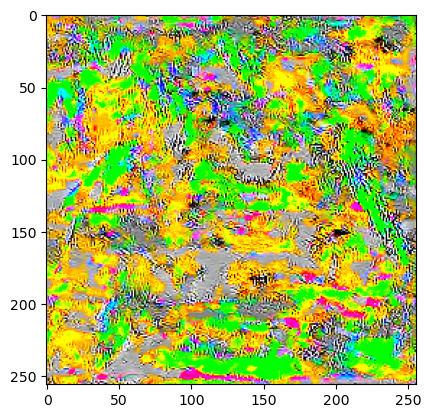

In [124]:
plt.imshow(img.permute(1, 2, 0).detach().cpu().numpy())

## Dataset

In [125]:
import os
import random
import json
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import json

class Image_Dataset(Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, resolution=(128, 128), root_dir="/home/benedikthopf/Dokumente/9. Semester/datasets/CANDLE", filetype="png"):
        super(Image_Dataset, self).__init__()
        self.resolution = resolution

        assert split in ['train', 'val', 'test']
        self.split = split
        self.root_dir = root_dir
        # self.root_dir = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"
        self.files = [file for file in os.listdir(
            self.root_dir) if file.endswith(f".{filetype}")]
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]
        self.img_transform = transforms.Compose([
            transforms.ToTensor()])

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)
        sample = {'image': image}

        return sample

    def __len__(self):
        return len(self.files)

## DINOSAUR

In [126]:
from pg_modules.dinosaur import DINOSAUR
from pg_modules.ti_slots import SlotRecreater

In [127]:
encoder_name = "vit_base_patch8_224_dino"
slot_dim = 256
n_slots = 7
dinosaur = DINOSAUR(n_slots, 3, slot_dim, 2048, encoder_name=encoder_name,
                         use_transformer=True).to("cuda")
if DATASET_NAME == "bedroom":
    dinosaur.load_state_dict(torch.load(
        f'../models/dinosaur_bedroom.ckpt')['model_state_dict'])
elif DATASET_NAME == "bedroom_ti":
    dinosaur = SlotRecreater(oc_type="DINOSAUR", feature_extractor="resnet34").to("cuda")
    dinosaur.load_state_dict(torch.load(
        f'../models/ti_slots_r34_bedroom.ckpt')['model_state_dict'])
else:
    dinosaur.load_state_dict(torch.load(
        f'../models/model_vit_base_patch8_224_dino_dataset.COCO_transformerTrue.ckpt')['model_state_dict'])

In [128]:
dataset_path_by_name = {
    "dogs_faces": "../../datasets/few-shot-images/AnimalFace-dog/img",
    "cat_faces": "../../datasets/few-shot-images/AnimalFace-cat/img/",
    "dogs": "../../datasets/SDIP/dog/",
    "fauvism": "../../datasets/few-shot-images/fauvism-still-life/img",
    "moongate": "../../datasets/few-shot-images/moongate/img/",
    "bedroom": "../../datasets/bedroom/",
    "bedroom_ti": "../../datasets/bedroom/"
}

In [129]:
#train_set = Image_Dataset("train", resolution=(224, 224), root_dir="/home/benedikthopf/Dokumente/9. Semester/datasets/few-shot-images/moongate/img/", filetype="jpg")
train_set = Image_Dataset("train", resolution=(224, 224), root_dir=dataset_path_by_name[DATASET_NAME], filetype="jpg" if not "bedroom" in DATASET_NAME else "webp")
#train_set = Image_Dataset("train", resolution=(224, 224), root_dir="/home/benedikthopf/Dokumente/9. Semester/datasets/few-shot-images/AnimalFace-dog/img", filetype="jpg")

In [130]:
def show_tensor(t, ax=None):
    if ax:
        ax.imshow(t.permute(1, 2, 0).detach().cpu().numpy())
    else:
        plt.imshow(t.permute(1, 2, 0).detach().cpu().numpy())

In [131]:
def get_slots(img):
    with torch.no_grad():
        if isinstance(dinosaur, DINOSAUR):
            _, x = dinosaur.encode(img)
            slots, _ = dinosaur.slot_attention(x)
            slots = slots.detach()
        else:
            _, slots, _ = dinosaur(img)
    return slots

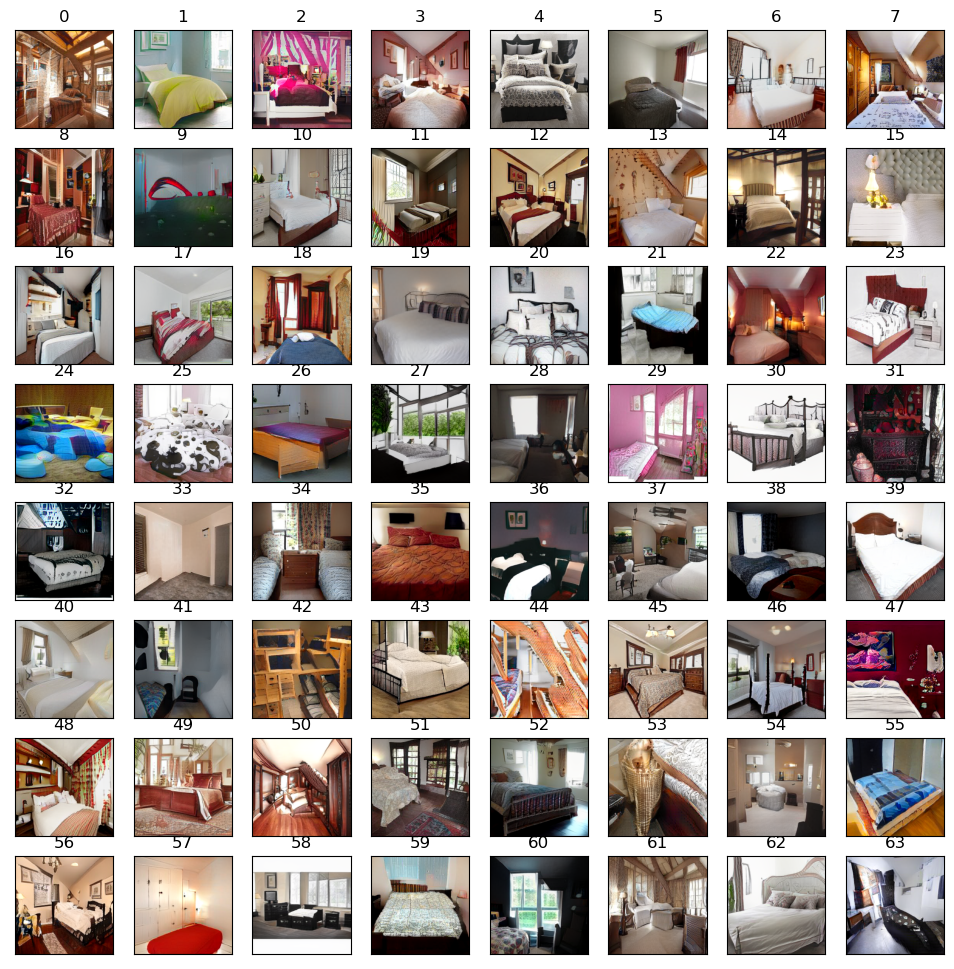

In [132]:
fig, axss = plt.subplots(8, 8, figsize=(12, 12))
i = 0
for axs in axss:
    for ax in axs:
        torch.manual_seed(1)
        slots = get_slots(train_set[i]["image"].to("cuda").unsqueeze(0))
        img = get_image(G, slots).squeeze()
        show_tensor(img, ax)
        ax.set_title(i)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        i += 1

In [134]:
img_1_nr = 48
img_2_nr = 39

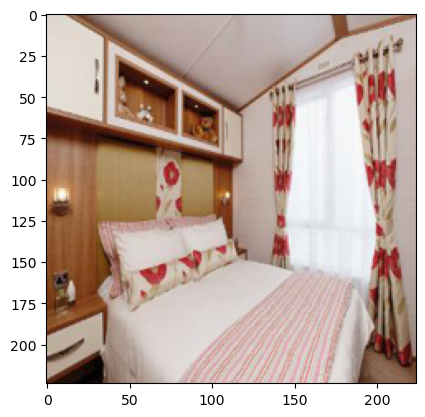

In [135]:
show_tensor(train_set[img_1_nr]["image"])

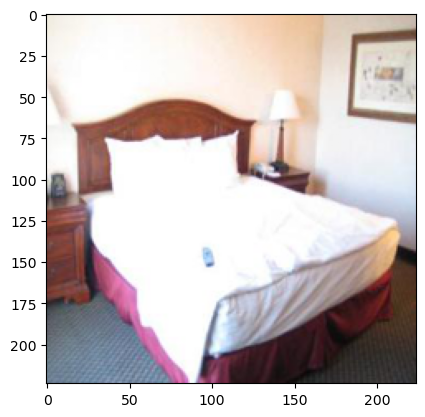

In [136]:
show_tensor(train_set[img_2_nr]["image"])

In [137]:
img1 = train_set[img_1_nr]["image"].to("cuda")
img2 = train_set[img_2_nr]["image"].to("cuda")

In [138]:
torch.manual_seed(1)
slots1 = get_slots(img1.unsqueeze(0))
torch.manual_seed(1)
slots2 = get_slots(img2.unsqueeze(0))

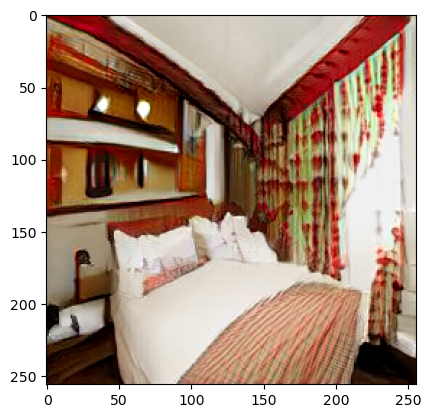

In [139]:
show_tensor(get_image(G, slots1)[0])

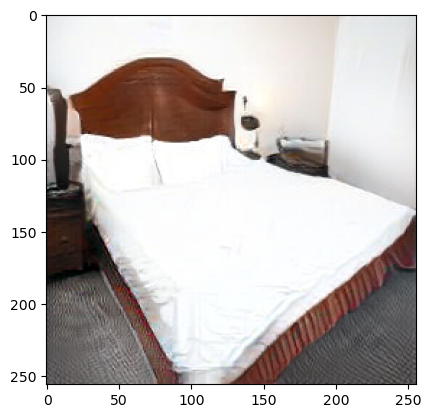

In [140]:
show_tensor(get_image(G, slots2)[0])

In [141]:
from pg_modules.helper import DinoAutoencoder

In [142]:
decoder = DinoAutoencoder("vit_base_patch8_224_dino").to("cuda")
decoder.load_state_dict(torch.load("./pg_modules/dinodecoder_vit_base_patch8_224_dino_dataset.COCO.ckpt")["model_state_dict"])

<All keys matched successfully>

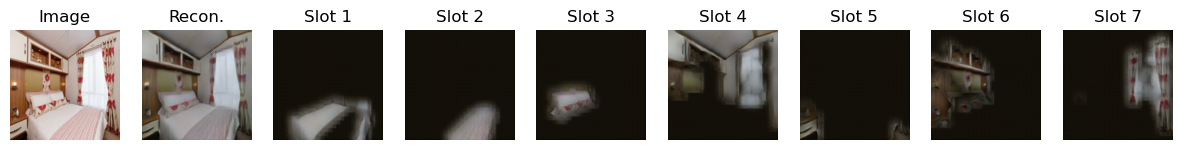

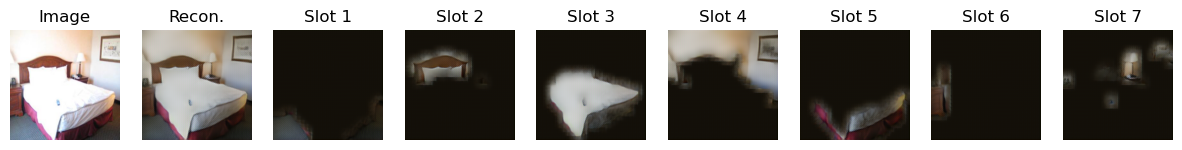

In [143]:
for image in (img1, img2):
    image = image.clone().unsqueeze(0)

    torch.manual_seed(1)
    features, recon_combined, recons, masks, slots = dinosaur(image)
    b, n, c = features.shape
    mask_width_height = int(n**0.5)
    recon_combined = recon_combined.permute(0, 2, 1).reshape(b, c, mask_width_height, mask_width_height)
    recons = recons.permute(0, 1, 3, 2).reshape(-1, c, mask_width_height, mask_width_height)
    masks = masks.reshape(-1, 1, mask_width_height, mask_width_height)

    recon_images = decoder.decode(recons*masks)
    recon_combined_image = decoder.decode(recon_combined)

    fig, ax = plt.subplots(1, n_slots + 2, figsize=(15, 2))
    image = image.squeeze(0)
    recon_combined_image = recon_combined_image.squeeze(0)
    image = image.permute(1,2,0).cpu().numpy()
    recon_combined_image = recon_combined_image.permute(1,2,0)
    recon_combined_image = recon_combined_image.cpu().detach().numpy().clip(0,1)
    recon_images = recon_images.permute(0,2,3,1)
    recon_images = recon_images.cpu().detach().numpy().clip(0,1)
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(recon_combined_image)
    ax[1].set_title('Recon.')
    for i in range(7):
        ax[i + 2].imshow(recon_images[i])
        ax[i + 2].set_title('Slot %s' % str(i + 1))
    for i in range(len(ax)):
        ax[i].grid(False)
        ax[i].axis('off')

In [144]:
def show_interpolation(lmbd, index=-1):            
    if index < 0:
        slots = lmbd*slots1 + (1-lmbd)*slots2
    elif index == 7:
        slots = slots1.clone()
        #slots[..., 0, :] = lmbd*slots1[..., 0, :] + (1-lmbd)*slots2[..., 2, :]
        slots[..., 5, :] = lmbd*slots1[..., 5, :] + (1-lmbd)*slots2[..., 6, :]
    else:
        slots = slots1.clone()
        slots[..., index, :] = lmbd*slots1[..., index, :] + (1-lmbd)*slots2[..., index, :]
    show_tensor(get_image(G, slots)[0])

In [145]:
from ipywidgets import interact, FloatSlider, IntSlider

In [146]:
interact(show_interpolation, lmbd=FloatSlider(min=0, max=1, value=0), index=IntSlider(min=-1, max=7, value=-1))

interactive(children=(FloatSlider(value=0.0, description='lmbd', max=1.0), IntSlider(value=-1, description='in…

<function __main__.show_interpolation(lmbd, index=-1)>

In [67]:
from PIL import Image
from tqdm import tqdm

In [68]:
def save_tensor_image(filename, t, drange=(0, 1)):
    l, h = drange
    t = (t - l) / (h - l)
    return matplotlib.image.imsave(filename, t.permute(1, 2, 0).detach().cpu().numpy())

In [116]:
save_tensor_image(f"images/{DATASET_NAME}_real_{img_1_nr}.png", img1)
save_tensor_image(f"images/{DATASET_NAME}_fake_{img_1_nr}.png", get_image(G, slots1)[0])
save_tensor_image(f"images/{DATASET_NAME}_real_{img_2_nr}.png", img2)
save_tensor_image(f"images/{DATASET_NAME}_fake_{img_2_nr}.png", get_image(G, slots2)[0])
slots = slots1.clone()
#slots[..., 3, :] = slots2[..., 3, :]
#slots[..., 2, :] = slots2[..., 4, :]
#slots[..., 6, :] = slots2[..., 6, :]
lmbd = 0
slots[..., 5, :] = lmbd*slots1[..., 5, :] + (1-lmbd)*slots2[..., 6, :]
save_tensor_image(f"images/{DATASET_NAME}_composite_{img_1_nr}_{img_2_nr}.png", get_image(G, slots)[0])

## Interpolation

In [33]:
def do_interpolation(lmbd, index=-1):
    if type(index) == list:
        slots = slots1.clone()
        for i in index:
            slots[..., i, :] = lmbd*slots1[..., i, :] + (1-lmbd)*slots2[..., i, :]
    elif index < 0:
        slots = lmbd*slots1 + (1-lmbd)*slots2
    elif index == 7:
        slots = slots1.clone()
        slots[..., 2, :] = lmbd*slots1[..., 2, :] + (1-lmbd)*slots2[..., 0, :]
    else:
        slots = slots1.clone()
        slots[..., index, :] = lmbd*slots1[..., index, :] + (1-lmbd)*slots2[..., index, :]
    return get_image(G, slots)[0]

In [34]:
images = []
for lmbd in tqdm(np.concatenate([np.linspace(0, 1, 60), np.linspace(1, 0, 60)])):
    img = do_interpolation(lmbd, index=7).squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.int8)
    img = Image.fromarray(img, mode="RGB")
    images.append(img)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 43.48it/s]


In [35]:
images[0].save("../demopictures/bedroom_interpolation_direct.gif", 
               save_all=True, 
               append_images=images[1:], 
               duration=10,
               loop=0,
               optimize=True,
               include_color_table=True)

# PCA

In [43]:
bs = 8
num_batches = 12
modslot=2

In [44]:
for i in tqdm(range(num_batches)):
    batch = torch.stack([train_set[i*bs+j]["image"] for j in range(bs)]).to("cuda")
    dinosaur.add_to_PCA_dataset(batch, label_fn=lambda i, m: "ignored" if i != modslot else "")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.18it/s]


In [45]:
dinosaur.learn_PCA()

In [46]:
def get_offset(coordinates, offsets, size=256):
    offset = np.zeros(size, dtype=np.float32)
    for c, o in zip(coordinates, offsets):
        offset[c] = o
    return offset

In [47]:
def show_pca(lmbd, i=0):
    _, _, _, _, slots = dinosaur.modify(train_set[img_1_nr]["image"].unsqueeze(0).to("cuda"), get_offset([i], [lmbd], size=dinosaur.principal_slot_components.shape[0]), modslot=modslot)
    show_tensor(get_image(G, slots).squeeze(0))

In [48]:
interact(show_pca, lmbd=FloatSlider(min=-2, max=2, value=0), i=IntSlider(min=0, max=30, value=0))

interactive(children=(FloatSlider(value=0.0, description='lmbd', max=2.0, min=-2.0), IntSlider(value=0, descri…

<function __main__.show_pca(lmbd, i=0)>

In [49]:
def do_pca(lmbd, i=0, modslot=modslot, size=256):
    _, _, _, _, slots = dinosaur.modify(train_set[img_1_nr]["image"].unsqueeze(0).to("cuda"), get_offset([i], [lmbd], size=size), modslot=modslot)
    return get_image(G, slots)

In [50]:
for lmbd in tqdm([-0.5, 0, 0.5, 1]):
    img = do_pca(lmbd, i=0, modslot=modslot, size=dinosaur.principal_slot_components.shape[0]).squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.int8)
    img = Image.fromarray(img, mode="RGB")
    img.save(f"images/{DATASET_NAME}_{img_1_nr}_pca_{lmbd}.png")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.70it/s]


In [52]:
images = []
for lmbd in tqdm(np.concatenate([np.linspace(-0.7, 1, 60), np.linspace(1, -0.7, 60)])):
    img = do_pca(lmbd, i=0, modslot=modslot, size=dinosaur.principal_slot_components.shape[0]).squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.int8)
    img = Image.fromarray(img, mode="RGB")
    images.append(img)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.91it/s]


In [53]:
images[0].save("../demopictures/bedroom_pca_bed_size.gif", 
               save_all=True, 
               append_images=images[1:], 
               duration=15,
               loop=0,
               optimize=True,
               include_color_table=True)